## Iron Oxide Solution (FeO)

In [1]:
#Data Visualization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

#Data Conversion
from IPython.display import HTML, SVG
import numpy as np
from svgpath2mpl import parse_path
from operator import itemgetter
import json

#Solving Equations
from sympy import Eq, Symbol, solve

In [2]:
#Pulling in Fe-O system data, json downloaded manually from MPDS

f = open('\data\Fe-O\FeO_v2.json')
data = json.load(f)

data

{'temp': [0.8, 1600.0],
 'arity': 2,
 'entry': 'C103304',
 'naxes': 2,
 'labels': [['L', [0.1875714830346931, 1513.6772427774963], None],
  ['(Fe) rt', [0.0360022874571231, 131.2811028889423], 4402],
  ['(Fe) rt', [0.02321768966831872, 1360.4847440446022], 4402],
  ['(Fe) ht', [0.0360022874571231, 853.7863699948724], 12],
  ['L<sub>1</sub> + L<sub>2</sub>',
   [0.4405642394205109, 1511.245615813482],
   None],
  ['(Fe) rt + Fe<sub>0.92</sub>O ht',
   [0.27701105604269916, 211.94627470856562],
   5342],
  ['(Fe) ht + Fe<sub>0.92</sub>O ht',
   [0.27701105604269916, 828.7689812468323],
   5342],
  ['(Fe) ht + L<sub>2</sub>', [0.27701105604269916, 1139.2066903193108], 12],
  ['(Fe) rt + L<sub>2</sub>', [0.27701105604269916, 1383.990471363406], 4402]],
 'shapes': [{'kind': 'phase',
   'label': 'L',
   'nphases': 1,
   'svgpath': 'M 0.000228746,1495.02 L 0.018839,1493.72 L 0.0376389,1492.34 L 0.0376391,1492.34 L 0.0564025,1490.89 L 0.0564027,1490.89 L 0.0751282,1489.38 L 0.0751285,1489.38 L

The function below uses the specified material system to extract solidus curves into matplotlib compatible path. Accepts phase diagram data in JSON format. Function uses the same error handling developed for the extract_MPDS_liquidus function.

In [3]:
def extract_MPDS_Solidus(MPDS_json, verbose=True):
    if MPDS_json['reference'] is None:
        if verbose:
            print("system JSON does not contain any data!\n")
        return None

    components = MPDS_json['chemical_elements']
    if verbose:
        print("reading MPDS solidus from entry at " + MPDS_json['reference']['entry'] + "...\n")
    
    # extract solidus curve svgpath from system JSON
    curves = ""
    for boundary in MPDS_json['shapes']:
        if 'label' in boundary and boundary['label'] != 'L':
            curves = curves + boundary['svgpath']
            continue
    if not data:
        if verbose:
            print("no solidus data found in JSON!")
        return None
    
    path = parse_path(curves)

    
    # return matplotlib path
    return path, path.vertices, path.codes


In [4]:
FeOpath, vert, b_code= extract_MPDS_Solidus(data, verbose=True)

reading MPDS solidus from entry at https://mpds.io/entry/C103304...



In [5]:
b_code[0:-1]

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2], dtype=uint8)

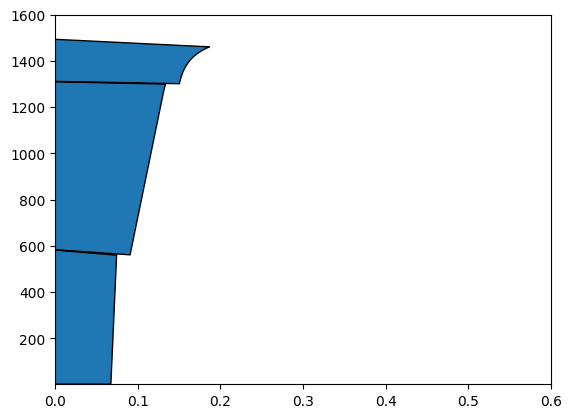

In [6]:
#Using Matplotlib patches to plot Fe-O system diagram

fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(FeOpath)
ax.add_patch(patch)
ax.set_ylim(data['temp'][0],data['temp'][1])
ax.set_xlim(data['comp_range'][0],data['comp_range'][1])
plt.show()

#### Data Cleaning

Temperature axis appears to be off scale. Temperature values in the JSON file do not reflect the values represented in the official version of the phase diagram. Will correct for this through linear transformation of the data.

In [7]:
new_vert= [[float(i[0]) *1, (float(i[1])/1.45)+ 500] for i in vert]
new_path = Path(new_vert,b_code)

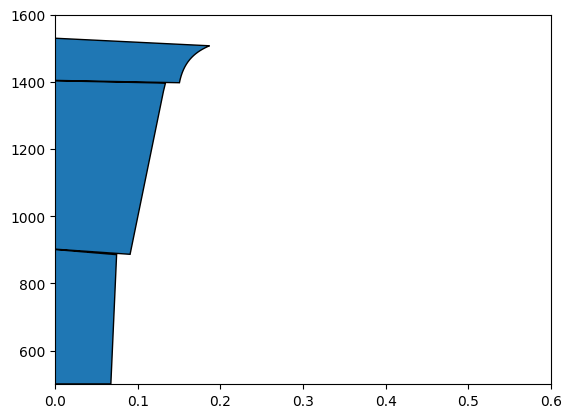

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(new_path)
ax.add_patch(patch)
ax.set_ylim(500,1600)
ax.set_xlim(data['comp_range'][0],data['comp_range'][1])
plt.show()

#### Calculating Solubility Limit

The function below pulls the temperature and fractional composition at the rightmost point of each phase. Solubility limits of each phase will be assumed at these boundaries. It is worth exploring more advanced methods of calculating the solubility limit through a series of equations to generate a gibbs free energy vs. fractional coposition diagram.

In [9]:
def extract_solubility_limit(path):
    # convert to coordinates in fractional composition, kelvin
    vertices = [[float(i[0])/100 , float(i[1])+273.15] for i in path._vertices]
    codes = path._codes

    sections=[]
    ind = 0
    solubility_limits = []

    for i in range(0,len(vertices)-1):
        if (codes[i+1] == 1 or None):
            b = i + 1
            sections.append(vertices[ind:b])
            ind = b
        else: 
            continue

    sections.append(vertices[ind:])

    
    for section in sections:
        # Sort by X (descending), determinding the rightmost point of the given svgpath
        sorted_coordinates= sorted(section, key=lambda c: ( -c[0]))
        solubility_limits.append(sorted_coordinates[0])

    return solubility_limits


In [10]:
extract_solubility_limit(new_path)

[[0.0018693299999999998, 1780.5706896551724],
 [0.0013364100000000001, 1669.5086206896553],
 [0.000745616, 1158.8962068965516]]

 1807.63 K is the transition temperature from Fe(BCC) to liquid , 1649.705 K is the transition temperature from Fe(FCC) to Fe(BCC), and 1172.24 K is the transition temperature from Fe(BCC) to Fe(FCC)

In [11]:
#Formation energy is stored in units of eV/atom in Materials Project, creating conversion function to put in correct units.

def convert_formation_energy(eV_atom):
    J_mol= eV_atom*(1.6*10**-19)*(6.02*10**23)

    return J_mol


In [12]:
def calculate_gibbs_free_energy(Tm,molEntr,T,transEnth):
    #Tm is the phase transition temperature (units:  Kelvin)
    # molEntr is Molar Entropy (units: J/mol/K)
    # T is Temperature (units: Kelvin)
    #transEnth is transition enthalpy (units: J/mol)

    
    deltaS = transEnth/Tm
    G_CS1 = (-T)*(molEntr)
    deltaG = transEnth -(T*deltaS)
    G_CS2 = G_CS1 + deltaG

    return G_CS2

In [13]:
def solve_mixing_enthalpy(G, x, y, T, formEng, R=8.314):
    # G is Gibbs Free Energy (units: J/mol)
    # x is solubility limit (units:fractional composition)
    # y is the composition of competing oxide (units:fractional composition)
    # T is observed temperature (units: Kelvin)
    # formEng is Formation energy (units: J/mol)
    # R is ideal gas constant (units: J/mol_K)

    w = Symbol('w')

    eqn = (G + w*x*(1-x)+R*T*(x*np.log(x)+(1-x)*np.log(1-x))) + (y-x) *(w-2*w*x+R*T*(np.log(x)-np.log(1-x))) - formEng

    return solve(eqn)
    


In [14]:
#Solving Fe-O Exam Problem from MSE 532 - A check to see if functions calculate correctly

G_FCC_init  = calculate_gibbs_free_energy(900, 27, 1373,1000)

solve_mixing_enthalpy(G_FCC_init, 0.003, 0.521, 1373, -175300)

[-199153.910612293]

In [15]:
#From Materials Project mp-18905 FeO system, predicted formation energy
convert_formation_energy(-1.643)

-158253.76

- Enthalpy change for Fe(BCC) to Fe(FCC) is not available on MPDS
- Molar entropy  of Fe: https://mpds.io/#inquiry/elements=Fe&classes=unary&props=entropy


In [16]:
# deltaG (Fe_BCC -> Fe_FCC) at 0 degrees K

G_FCC  = calculate_gibbs_free_energy(1172.2424999999998, 27.3, 1373,1000)

solve_mixing_enthalpy(G_FCC, 0.0018693299999999998, 0.5, 0, -158253.76)

[-242102.648764969]